<a href="https://colab.research.google.com/github/TurnipPudding/Machine-Learning---SCC0276/blob/main/Trabalho%202/trab02_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA


In [90]:
!git clone https://github.com/TurnipPudding/Machine-Learning---SCC0276.git
# df = pd.read_csv("processed_microplastics.csv")

fatal: destination path 'Machine-Learning---SCC0276' already exists and is not an empty directory.


In [91]:
print('/content/')

/content/


## Funções Genéricas

### Modelo Genérico

In [92]:
def run_model(model, X_scaled, crossval_results, feature_names=None):
    labels = model.fit_predict(X_scaled)

    silhouette = float(silhouette_score(X_scaled, labels))
    ch_score = float(calinski_harabasz_score(X_scaled, labels))
    db_score = float(davies_bouldin_score(X_scaled, labels))

    crossval_results.append((silhouette, ch_score, db_score))

    # Salvar centróides se for KMeans
    if hasattr(model, 'cluster_centers_') and feature_names is not None:
        centroids_df = pd.DataFrame(model.cluster_centers_, columns=feature_names)
        return labels, crossval_results, centroids_df

    return labels, crossval_results, None

### PCA

In [93]:
def pca_gen(X_scaled, df, column, title, feature_names=None, return_loadings=False):
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X_scaled)
    df['PC1'] = pca_components[:, 0]
    df['PC2'] = pca_components[:, 1]

    # print(len(title))
    # print(len(column))
    # Preparar os plots
    fig, axs = plt.subplots(1, len(title), figsize=((len(title) * 6), 5))

    if len(title) == 1:
        axs = [axs]
    # PCA scatter plots
    for i in range(len(title)):
        sns.scatterplot(data=df, x='PC1', y='PC2', hue=column[i], ax=axs[i]).set_title(title[i])
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='dbscan', ax=axs[1]).set_title("DBSCAN")
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='agglo', ax=axs[2]).set_title("Agglomerative")

    plt.tight_layout()
    plt.show()

    # Se quiser retornar os pesos (cargas) do PCA
    if return_loadings and feature_names is not None:
        loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)
        explained_var = pca.explained_variance_ratio_
        return loadings_df, explained_var

    return None, None

#### Gráfico de Visualização do PCA

In [94]:
def plot_pca_loadings_barras(loadings_df, component, top_n, title):
    """
    Plota os top_n alimentos com maior influência no componente principal especificado.

    Parâmetros:
    - loadings_df: DataFrame de pesos (output do PCA).
    - component: 'PC1', 'PC2', etc.
    - top_n: número de alimentos mais influentes a mostrar.
    - title: título opcional do gráfico.
    """
    fig, axs = plt.subplots(1, len(component), figsize=((len(component) * 6), 5))

    for i in range(len(component)):
    # Seleciona os valores absolutos mais influentes
        abs_loadings = loadings_df[component[i]].abs().sort_values(ascending=False).head(top_n)
        selected_features = loadings_df.loc[abs_loadings.index, component[i]]


    # Plot
    # plt.figure(figsize=(10, 6))
        sns.barplot(x=selected_features.values,
                    y=selected_features.index, palette="viridis",
                    hue=selected_features.index, ax=axs[i])
        axs[i].set_xlabel(f'Carga no {component[i]}')
        axs[i].set_ylabel('Alimento')
        axs[i].set_title(f'Top {top_n} alimentos mais influentes em {component[i]} de {title}')
    # plt.xlabel(f'Carga no {component}')
    # plt.ylabel('Alimento')
    # plt.title(f'Top {top_n} alimentos mais influentes em {component} de {title}')
    # plt.grid(True)
    plt.tight_layout()
    plt.show()


### Boxplot

In [137]:
# def boxplot_gen(df, column, title):
#     fig, axs = plt.subplots(1, len(title), figsize=((len(title) * 6), 5))

#     if len(title) == 1:
#         axs = [axs]

#     for i in range(len(title)):
#         sns.boxplot(data=df, x=column[i], y='index_risk_country', ax=axs[i])
#         axs[i].set_title(f"Boxplot do índice de risco por cluster ({title[i]})")
#         axs[i].set_xlabel("Cluster")
#         axs[i].set_ylabel("Índice de Risco")

#     plt.tight_layout()
#     plt.show()
def boxplot_gen(df, alimentos, column, title):
    """
    Gera boxplots para cada alimento comparando os clusters.

    Parâmetros:
    - df: DataFrame contendo as colunas de alimentos e a de cluster.
    - alimentos: lista com os nomes das colunas de alimentos.
    - cluster_col: nome da coluna dos rótulos de cluster.
    - title_prefix: prefixo para os títulos dos gráficos.
    """
    # import seaborn as sns
    # import matplotlib.pyplot as plt
    n_rows = len(alimentos)
    n_cols = len(column)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=((n_cols * 6), n_rows * 5), squeeze=False)

    # if len(column) == 1:
    #     axs = [axs]


    for row_idx, alimento in enumerate(alimentos):
        for col_idx, cluster_col in enumerate(column):
            # cluster_col = df[column[i]]
            # print(cluster_col)
            ax = axs[row_idx][col_idx] # if n_cols > 1 else axs[col_idx]
            sns.boxplot(data=df, x=cluster_col, y=alimento, ax=ax, hue=cluster_col, palette='Set2')
            ax.set_title(f'Consumo de {alimento} por cluster ({title[col_idx]})')
            ax.set_xlabel('Cluster')
            ax.set_ylabel(f'{alimento} consumption')
            ax.grid(True)

    plt.tight_layout()
    plt.show()
    # # for alimento in alimentos:
    #     plt.figure(figsize=(8, 5))
    #     sns.boxplot(data=df, x=cluster_col, y=alimento, hue=cluster_col, palette='Set2')
    #     plt.title(f'{title_prefix}{alimento} por cluster')
    #     plt.xlabel('Cluster')
    #     plt.ylabel(f'{alimento} (consumo)')
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

### Heatmap

In [151]:
# Usar pivot para criar heatmap país x ano com índice
# def heatmap_gen(df):
    # pivot_df = df.pivot_table(index='country', columns='year', values='index_risk_country', aggfunc='mean')
    # plt.figure(figsize=(14, 10))
    # sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.5)
    # plt.title("Heatmap do Índice de Risco Alimentar por País e Ano")
    # plt.xlabel("Ano")
    # plt.ylabel("País")
    # plt.tight_layout()
    # plt.show()
def heatmap_gen(df, alimentos, column, title):
    """
    Gera um heatmap com a média de consumo dos alimentos por cluster.

    Parâmetros:
    - df: DataFrame com dados.
    - alimentos: lista de colunas de alimentos.
    - cluster_col: nome da coluna com os rótulos dos clusters.
    - title: título do gráfico.
    - cmap: colormap do heatmap.
    """
    fig, axs = plt.subplots(1, len(column), figsize=((len(column) * 6), 5), squeeze=False)

    # if len(column) == 1:
    #     axs = [axs]

    for i in range(len(column)):
        cluster_means = df.groupby(column[i])[alimentos].mean().T
        ax = axs[0][i]
        sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5, ax=ax)
        ax.set_title(f'Média de consumo dos alimentos por cluster ({title[i]})')
        ax.set_xlabel('Alimento')
        ax.set_ylabel('Cluster')

    plt.tight_layout()
    plt.show()
    # for i in range(len(column)):
    #     cluster_means = df.groupby(column[i])[alimentos].mean().T

    #     plt.figure(figsize=(12, 6))
    #     sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5)
    #     plt.title(f'Média de consumo dos alimentos por cluster ({title[i]})')
    #     plt.xlabel('Alimento')
    #     plt.ylabel('Cluster')
    #     plt.tight_layout()
    #     plt.show()



### Código para Análise por Ano

In [97]:
def clusterizacao_por_ano(df, col_index='index_risk_country'):
    resultados = []
    anos = sorted(df['year'].unique())

    for ano in anos:
        df_ano = df[df['year'] == ano].copy()

        # Normalização
        scaler = StandardScaler()
        X = scaler.fit_transform(df_ano[[col_index]])

        # Determinação do melhor k com Silhouette Score
        silhouette_scores = []
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            score = silhouette_score(X, labels)
            silhouette_scores.append((k, score))

        best_k = max(silhouette_scores, key=lambda x: x[1])[0]

        # Clusterização final
        final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        df_ano['cluster'] = final_kmeans.fit_predict(X)

        resultados.append(df_ano[['country', 'year', col_index, 'cluster']])

    return pd.concat(resultados, ignore_index=True)



### Código para Análise Geográfica

In [98]:
# --------------------------
# CÓDIGO PARA ANÁLISE GEOGRÁFICA
# --------------------------
def analise_geografica(df_clusterizado, col_index='index_risk_country'):
    return df_clusterizado.groupby('country').agg(
        media_risco=(col_index, 'mean'),
        cluster_mais_comum=('cluster', lambda x: x.mode().iloc[0] if not x.mode().empty else -1)
    ).reset_index()

## Carregando dados

In [99]:
df = pd.read_csv("/content/Machine-Learning---SCC0276/Trabalho 2/processed_microplastics.csv")
df.head(5)

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,...,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,...,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,...,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,...,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,...,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,...,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      723 non-null    int64  
 1   country                   723 non-null    object 
 2   cheese                    723 non-null    float64
 3   yoghurt                   723 non-null    float64
 4   total_milk                723 non-null    float64
 5   fruits                    723 non-null    float64
 6   refined_grains            723 non-null    float64
 7   whole_grains              723 non-null    float64
 8   nuts_and_seeds            723 non-null    float64
 9   total_processed_meats     723 non-null    float64
 10  unprocessed_red_meats     723 non-null    float64
 11  fish                      723 non-null    float64
 12  shellfish                 723 non-null    float64
 13  eggs                      723 non-null    float64
 14  total_salt

In [101]:
df.describe()

,year,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,2005.113416,6.135622,54.175691,250.655223,198.891339,310.733750,76.090720,12.716421,43.242799,90.326727,40.367154,7.415298,17.184714,6.844069,87.980939,232.405995,81.885598,64.300877,19.261638,1600.614574
std,9.610611,10.437505,77.868834,243.250670,150.271271,138.658231,81.578881,10.827892,39.223624,67.646655,34.835918,13.695479,14.584195,1.806978,60.331304,164.633624,83.109875,135.136514,16.758578,567.115360
min,1990.000000,0.000000,0.748435,1.808219,8.958904,72.797775,0.158798,0.000000,0.396227,6.583087,0.054795,0.000000,0.027397,2.278036,3.972603,16.931507,0.000000,0.000000,0.438356,440.261767
25%,1995.000000,0.273973,12.048883,50.342466,89.808219,216.258939,16.965904,4.561644,11.560798,33.837311,15.726027,0.191781,3.876712,5.845209,38.753425,118.287671,12.205479,0.493151,7.821918,1176.251294
50%,2005.000000,1.424658,35.390618,153.506849,179.945205,288.254183,47.164800,9.589041,29.473811,71.678223,31.232877,1.589041,13.780822,6.660399,83.698630,185.945205,49.561644,8.547945,14.794521,1550.939573
75%,2015.000000,6.082192,73.449547,400.890411,266.863014,383.983087,101.764947,18.410959,66.736055,134.673403,54.506849,8.630137,27.657534,7.659304,117.616438,292.479452,135.876712,59.123288,25.561644,2061.390253
max,2018.000000,65.643836,679.834239,1040.931507,1078.931507,890.394188,434.121124,73.068493,198.333731,477.301388,207.315068,151.863014,61.698630,12.430686,453.780822,1055.342466,362.712329,833.945206,124.575343,3613.131482


In [102]:
df.columns

Index(['year', 'country', 'cheese', 'yoghurt', 'total_milk', 'fruits',
       'refined_grains', 'whole_grains', 'nuts_and_seeds',
       'total_processed_meats', 'unprocessed_red_meats', 'fish', 'shellfish',
       'eggs', 'total_salt', 'added_sugars', 'non-starchy_vegetables',
       'potatoes', 'other_starchy_vegetables', 'beans_and_legumes',
       'total_ug_per_kg'],
      dtype='object')

## Analisando features

In [103]:
anos = df['year'].unique()
# print(anos)
paises = df['country'].unique()
# print(anos.shape)
# print(paises.shape)
# print(df.shape)

# Eu quero verificar que todos os anos possuem os mesmos países para fazer uma análise justa
lista_paises = []
for ano in anos:
    df_ano = df[df['year'] == ano]
    paises_ano = df_ano['country'].unique()
    lista_paises.append(paises_ano)

for i in range(len(lista_paises)):
    for j in range(len(lista_paises)):
        paises_dif = np.setdiff1d(lista_paises[i], lista_paises[j])
        if i != j and len(paises_dif) > 0:
            print(f"Países do ano {anos[i]} que não estão no ano {anos[j]} são: {paises_dif}")


Países do ano 2010 que não estão no ano 1990 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2010 que não estão no ano 1995 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2010 que não estão no ano 2000 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2010 que não estão no ano 2005 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2015 que não estão no ano 1990 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slovenia' 'Syria' 'Ukraine']
Países do ano 2015 que não estão no ano 1995 são: ['Belgium' 'Bosnia And Herzegovina' 'Croatia' 'Luxembourg' 'Montenegro'
 'Russia' 'Serbia' 'Slo

In [104]:
# Retiro as linhas do dataframe que contém os países na lista paises_dif

df = df[~df['country'].isin(paises_dif)]

# Separando as features de contaminação

colums_to_sum = df.columns.drop(['year', 'country', 'total_salt', 'added_sugars', 'total_ug_per_kg'])
colums_to_sum

Index(['cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
       'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
       'unprocessed_red_meats', 'fish', 'shellfish', 'eggs',
       'non-starchy_vegetables', 'potatoes', 'other_starchy_vegetables',
       'beans_and_legumes'],
      dtype='object')

In [105]:
#Somando o risco total de contaminação de todos os alimentos pra cada país

# df['total_risk'] = df[colums_to_sum].sum(axis=1)
# print(df['total_risk'])

In [106]:
#Definindo o índice de risco por país

# df['index_risk_country'] = (df['total_risk']*df['total_ug_per_kg']).round(2)
# print(df['index_risk_country'])

## Normalização

In [107]:
#Normalizando a feature 'index_risk_country'

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df[['index_risk_country']])
X_scaled = scaler.fit_transform(df[colums_to_sum])

## Testes com KMeans

In [108]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels, kmeans_cv, kmeans_centroids = run_model(kmeans, X_scaled, [])

### Cross-validation

In [109]:
print(kmeans_cv)

[(0.16543553437279707, 162.4970884946564, 2.08067122733283)]


### PCA

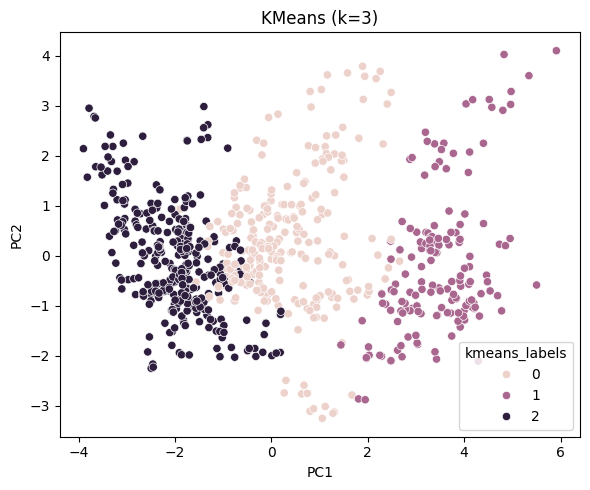

In [110]:
kmeans_column = 'kmeans_labels'
kmeans_title = 'KMeans (k=3)'

df[kmeans_column] = kmeans_labels

kmeans_loading_df, kmeans_explained_var = pca_gen(X_scaled=X_scaled, df=df,
                                                  column=[kmeans_column], title=[kmeans_title],
                                                  feature_names=colums_to_sum, return_loadings=True)

In [111]:
kmeans_loading_df

,PC1,PC2
cheese,0.328501,-0.068554
yoghurt,0.059491,-0.247439
total_milk,0.368179,-0.161367
fruits,0.193214,0.184998
refined_grains,-0.253022,0.108533
whole_grains,0.069553,-0.312246
nuts_and_seeds,0.034897,0.294229
total_processed_meats,0.319352,-0.143018
unprocessed_red_meats,0.359547,0.113468
fish,0.158905,0.562605


In [112]:
kmeans_explained_var

array([0.31625199, 0.10149284])

### Gráfico do PCA

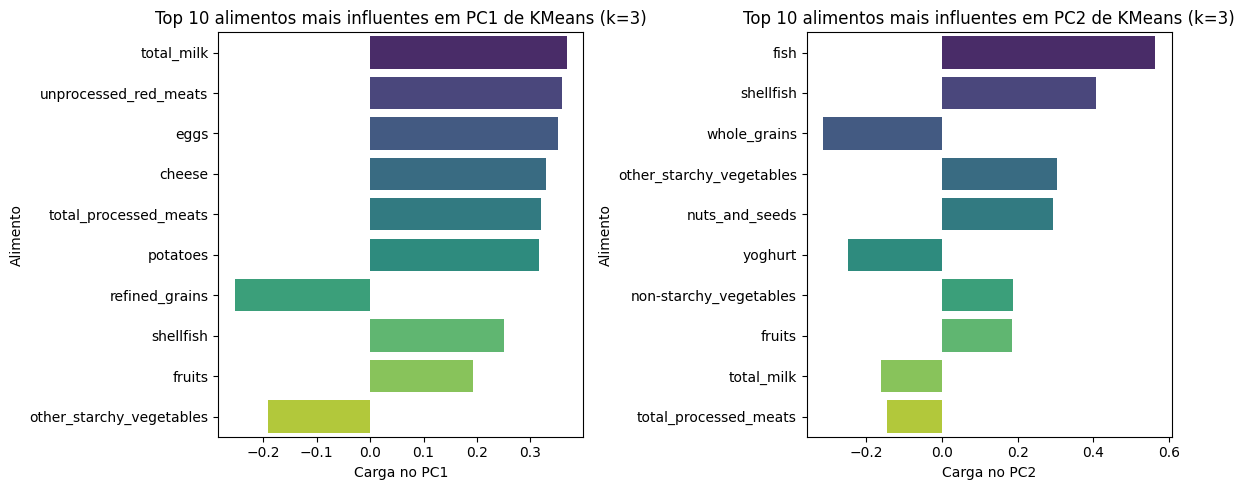

In [113]:
plot_pca_loadings_barras(kmeans_loading_df, component=['PC1', 'PC2'], top_n=10, title=kmeans_title)

### Boxplot

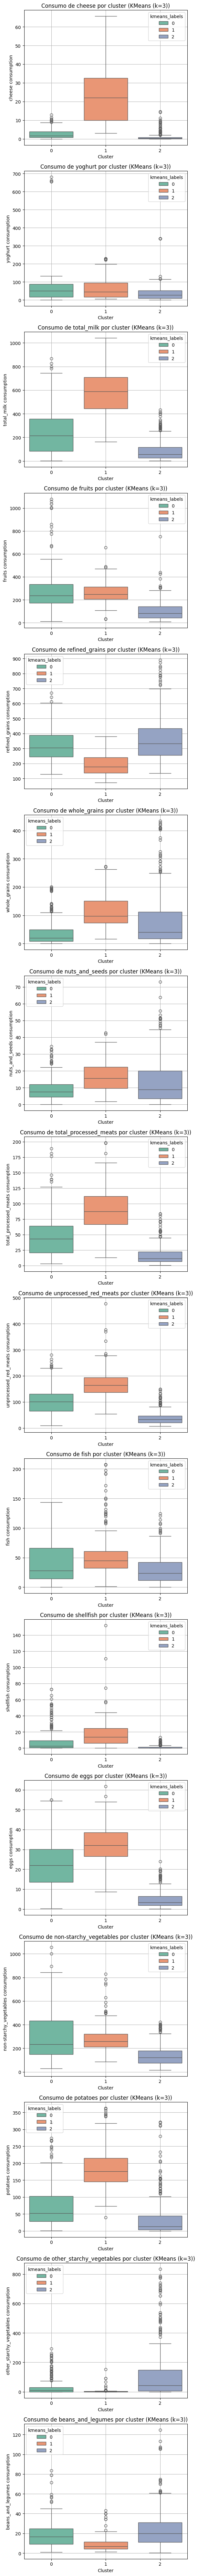

In [138]:
# boxplot_gen(df=df, column=[kmeans_column], title=[kmeans_title])
boxplot_gen(df, alimentos=list(colums_to_sum), column=[kmeans_column], title=[kmeans_title])

### Heatmap

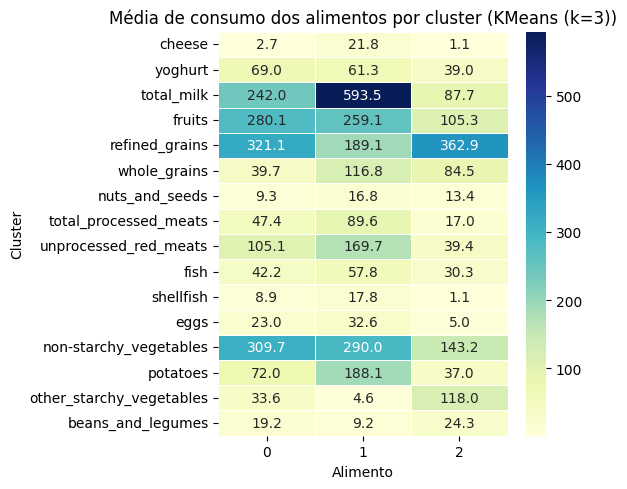

In [152]:
# heatmap_gen(df=df)
heatmap_gen(df, alimentos=list(colums_to_sum), column=[kmeans_column], title=[kmeans_title])

## Testes com DBSCAN

In [116]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels, dbscan_cv, _ = run_model(dbscan, X_scaled, [])

### Cross-validation

In [117]:
print(dbscan_cv)

[(-0.14347073086707862, 3.2158254834759794, 1.3994300737036078)]


### PCA

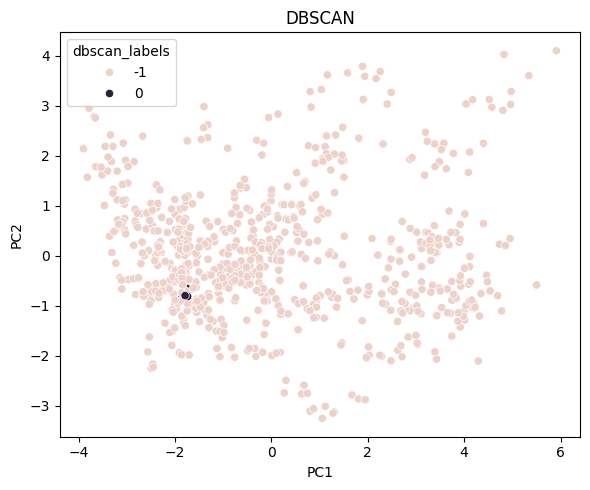

(None, None)

In [118]:
dbscan_column = 'dbscan_labels'
dbscan_title = 'DBSCAN'

df[dbscan_column] = dbscan_labels

pca_gen(X_scaled=X_scaled, df=df, column=[dbscan_column], title=[dbscan_title])

### Boxplot

In [119]:
# boxplot_gen(df=df, column=[dbscan_column], title=[dbscan_title])

### Heatmap

In [120]:
# heatmap_gen(df=df)

## Testes com Agglomerative Clustering

In [121]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels, agglo_cv, _ = run_model(agglo, X_scaled, [])

### Cross-validation

In [122]:
print(agglo_cv)

[(0.1324223343753308, 146.62037361726425, 2.2345606376294187)]


### PCA

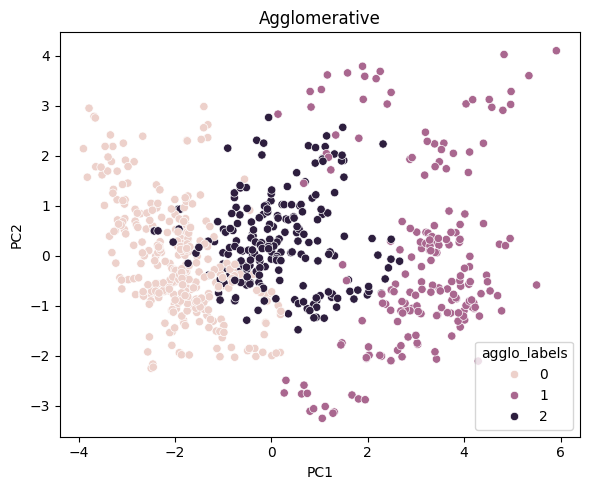

(None, None)

In [123]:
agglo_column = 'agglo_labels'
agglo_title = 'Agglomerative'

df[agglo_column] = agglo_labels

pca_gen(X_scaled=X_scaled, df=df, column=[agglo_column], title=[agglo_title])

### Boxplot

In [124]:
# boxplot_gen(df=df, column=[agglo_column], title=[agglo_title])

### Heatmap

In [125]:
# heatmap_gen(df=df)

## Análise entre modelos

### Cross-validation

In [126]:
models_cv = pd.DataFrame(index=[kmeans_title, dbscan_title, agglo_title],
             columns=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin]'],
             data=np.vstack([kmeans_cv, dbscan_cv, agglo_cv]))
models_cv


,Silhouette,Calinski-Harabasz,Davies-Bouldin]
KMeans (k=3),0.165436,162.497088,2.080671
DBSCAN,-0.143471,3.215825,1.399430
Agglomerative,0.132422,146.620374,2.234561


### PCA

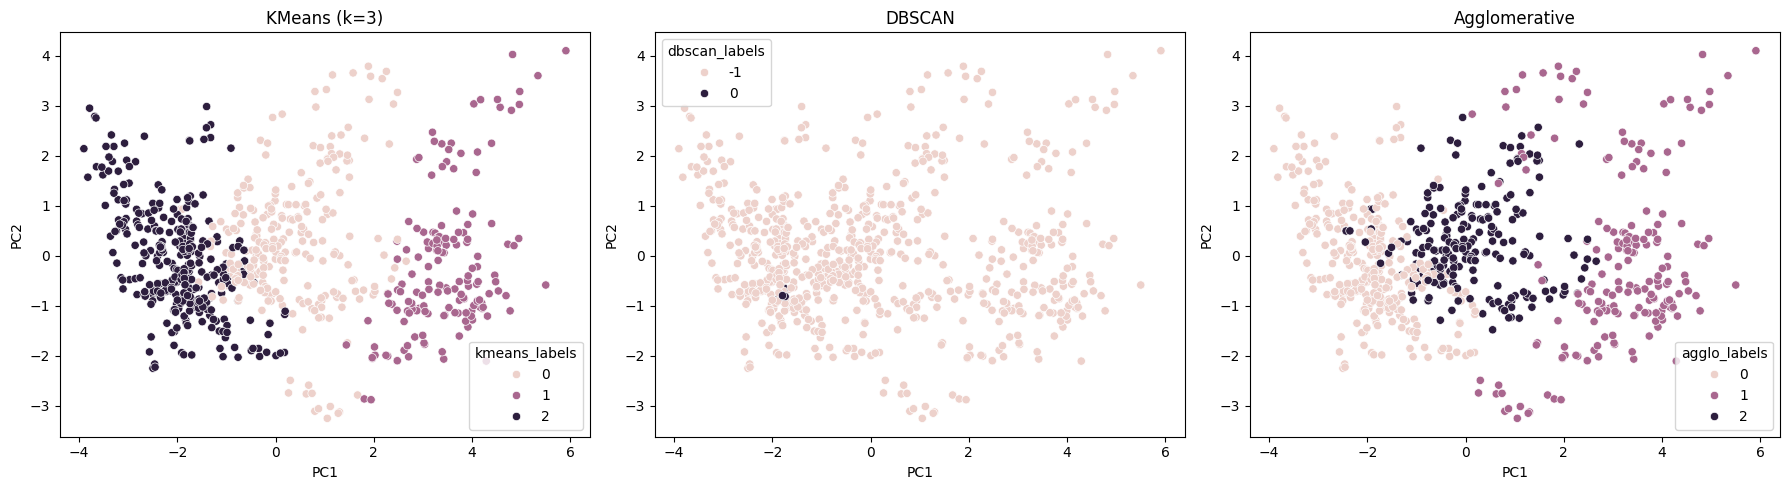

(None, None)

In [127]:
pca_gen(X_scaled=X_scaled, df=df,
        column=[kmeans_column, dbscan_column, agglo_column],
        title=[kmeans_title, dbscan_title, agglo_title])

### Boxplot

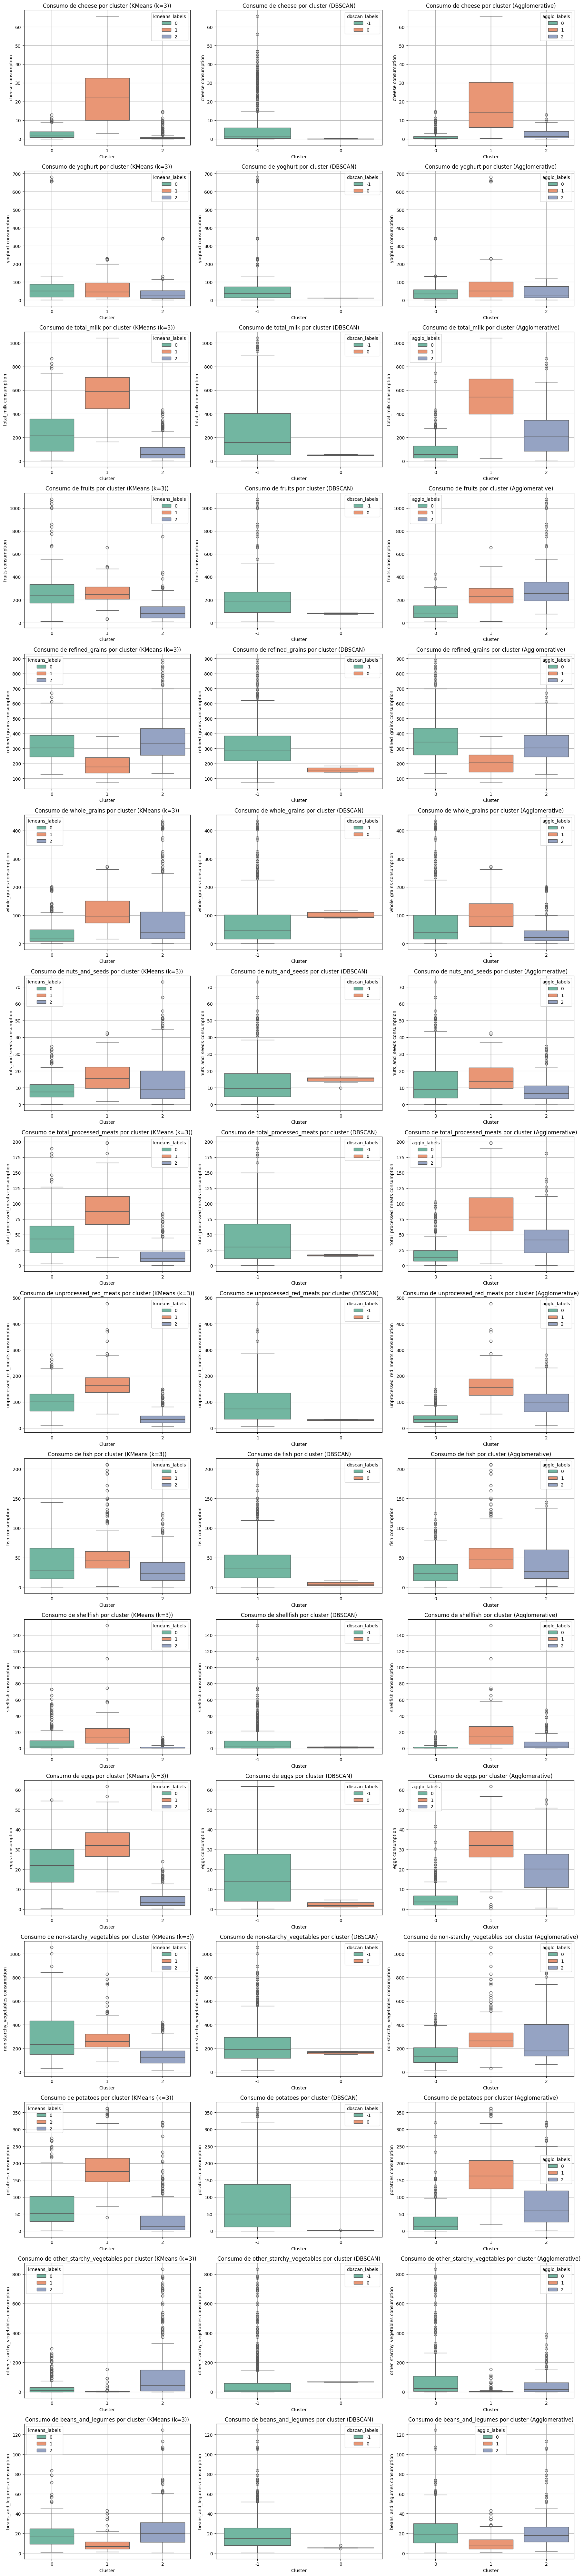

In [139]:
# boxplot_gen(df=df, column=[kmeans_column, dbscan_column, agglo_column],
#             title=[kmeans_title, dbscan_title, agglo_title])
boxplot_gen(df, alimentos=list(colums_to_sum), column=[kmeans_column, dbscan_column, agglo_column],
            title=[kmeans_title, dbscan_title, agglo_title])

### Heatmap

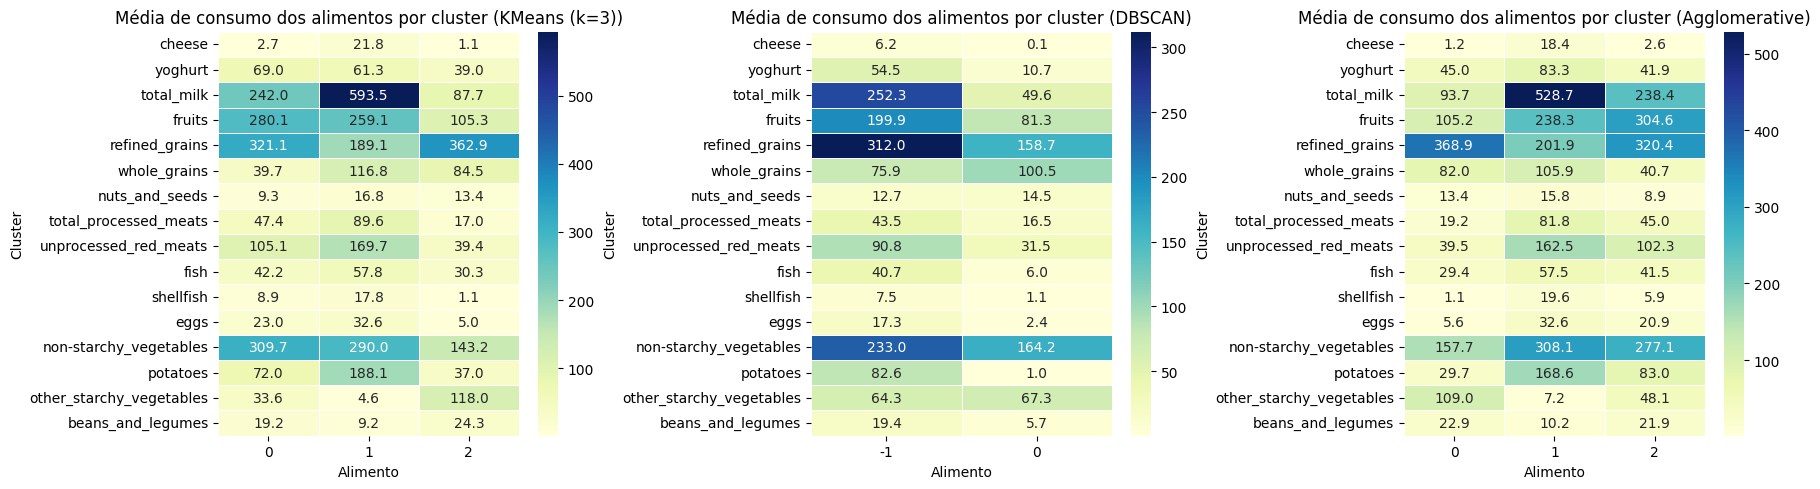

In [153]:
heatmap_gen(df, alimentos=list(colums_to_sum),
            column=[kmeans_column, dbscan_column, agglo_column],
            title=[kmeans_title, dbscan_title, agglo_title])

## Agrupando alimentos por cluster

In [129]:
df.groupby(kmeans_column)[colums_to_sum].mean()

,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes
kmeans_labels,,,,,,,,,,,,,,,,
0,2.728613,69.019025,241.997579,280.075920,321.095524,39.742208,9.298454,47.436530,105.068724,42.174506,8.870881,23.016449,309.708753,72.015404,33.580019,19.163888
1,21.795131,61.339876,593.450135,259.058197,189.051752,116.797809,16.811099,89.552477,169.726295,57.769828,17.800366,32.599773,289.984469,188.125643,4.636768,9.244220
2,1.056134,38.968224,87.680308,105.323020,362.859907,84.481151,13.373234,17.012962,39.422974,30.328508,1.128560,4.969362,143.168748,37.021218,117.981505,24.299728


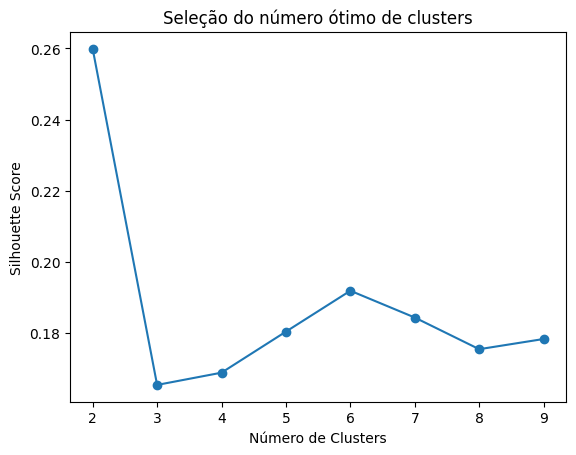

In [130]:
#Definição do número ideal de clusters via Silhouette Score

s_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    s_scores.append(silhouette_score(X_scaled, labels))

# Visualização
plt.plot(K, s_scores, marker='o')
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Seleção do número ótimo de clusters")
plt.show()

In [131]:
#Clusterização final com KMeans

best_k = K[s_scores.index(max(s_scores))]

kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


In [132]:
# print(df[['country','cluster']])

## Análise de Clusters

In [133]:
#Análise dos clusters

# Média do índice de risco por cluster
# df.groupby('cluster')['index_risk_country'].mean()

In [134]:
# sns.boxplot(data=df, x='cluster', y='index_risk_country')
# plt.title("Distribuição do índice de risco por cluster")

In [135]:
df_clusters_por_ano = clusterizacao_por_ano(df)
df_clusters_por_ano

KeyError: "None of [Index(['index_risk_country'], dtype='object')] are in the [columns]"

In [ ]:
df_resumo_geografico = analise_geografica(df_clusters_por_ano)
df_resumo_geografico

### CROSS-VALIDATION DOS CLUSTERS

In [ ]:

crossval_results = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    crossval_results.append((k, silhouette, ch_score, db_score))

crossval_results

## Testes com DBSCAN


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

## Testes com Agglomerative Clustering


In [ ]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_scaled)

In [ ]:
# Adicionar rótulos ao DataFrame para visualização
df['kmeans_3'] = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_scaled)
df['dbscan'] = dbscan_labels
df['agglo'] = agglo_labels

## Visualizações


### PCA


In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df['PC1'] = pca_components[:, 0]
df['PC2'] = pca_components[:, 1]

In [ ]:
# Preparar os plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# PCA scatter plots
sns.scatterplot(data=df, x='PC1', y='PC2', hue='kmeans_3', ax=axs[0]).set_title("KMeans (k=3)")
sns.scatterplot(data=df, x='PC1', y='PC2', hue='dbscan', ax=axs[1]).set_title("DBSCAN")
sns.scatterplot(data=df, x='PC1', y='PC2', hue='agglo', ax=axs[2]).set_title("Agglomerative")

plt.tight_layout()
plt.show()

### BOXPLOT


In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='kmeans_3', y='index_risk_country')
plt.title("Boxplot do índice de risco por cluster (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Índice de Risco")
plt.show()



In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='dbscan', y='index_risk_country')
plt.title("Boxplot do índice de risco por cluster (DBSCAN)")
plt.xlabel("Cluster")
plt.ylabel("Índice de Risco")
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='agglo', y='index_risk_country')
plt.title("Boxplot do índice de risco por cluster (Agglomerative Clustering)")
plt.xlabel("Cluster")
plt.ylabel("Índice de Risco")
plt.show()


### HEATMAP


In [ ]:
# Usar pivot para criar heatmap país x ano com índice
pivot_df = df.pivot_table(index='country', columns='year', values='index_risk_country', aggfunc='mean')
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap do Índice de Risco Alimentar por País e Ano")
plt.xlabel("Ano")
plt.ylabel("País")
plt.tight_layout()
plt.show()

# Retornar resultados de cross-validation
crossval_results